In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
import pandas as pd
import re
import array as arr
from scipy.stats import pearsonr

In [3]:
#google data load
google_trends = pd.read_csv('google-trends.csv')
google_trends.columns = ['week', 'data']
google_data = google_trends['data'].to_list()
print(google_data)

[0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 4, 3, 2, 9, 23, 100, 57, 38, 27, 14, 12, 13, 19, 15, 9, 7, 7, 7, 11, 9, 9, 6, 5, 3, 3, 3, 3, 3, 3]


# Monte Carlo 1: 0.75	10	0.01	0.75

In [23]:
infl_mod = pd.read_csv('monte-carlo-4_organizing.csv')
infl_mod.columns = ['run', 'n', 'spread-type', 'simple-spread-chance', 'ba-m', 'citizen-media-influence',
                  'citizen-citizen-influence','flint-organizing-strategy', 'organizing-capacity', 'repetition', 'data', "run_id"]
#process the csv and add columns to fill with metrics later

#short list represents both the shortened list to match the google trends data (114 weeks) and the processed data so that it
#is scaled out of 100 to better align with google data
infl_mod["short list"]=None
infl_mod['unscaled-list']=None
#threshold is a binary value representing whether or not the critical mass of the population has been reached (represented by
# 70%)
infl_mod['threshold'] = None
#peak-time is the time at which the peak will occur
infl_mod['peak-time']=None
#total spread is how many agents were reached in sum 
infl_mod['total-spread']=None



'''The three functions below are needed for data processing'''

def convertdata(data):
    sdata = data.strip(' ')
    ndata = nlogo_parse_chunk(sdata)
    n2data = [elem.replace('.', '') for elem in ndata]
    list=[]
    for x in n2data:
        list.append(x.replace("\r\n", ""))
    list = [i for i in list if i]
    return list

def nlogo_parse_chunk(chunk):
    chunk = chunk.strip().replace('"','')
    if chunk.count('[') > 1 and chunk[0] == '[':
        return nlogo_mixed_list_to_dict_rec(chunk[chunk.index('['):].strip())
    elif chunk.count('[') > 1 or chunk[0] != '[':
        return { chunk[0:chunk.index('[')].strip(): nlogo_mixed_list_to_dict_rec(chunk[chunk.index('['):].strip()) }

    pieces = chunk.strip().replace('[','').replace(']','').split(' ')
    if len(pieces) == 2:
        return { pieces[0]: pieces[1] }
    else:
        return pieces

def convert_to_int(data):
    for i in range(0, len(data)):
        data[i] = int(data[i])
    return data



'''This section goes through each simulation to update the dataframe with usable data and the metrics set up above'''
for i in range(0,infl_mod.shape[0]):
    thresh=0
    error=0

    
    #set cutoff to the number of agents that need to hear about Flint to be considered a success- for this model, total runs are 
    #500 agents, so 350 represents 70% of them
    #cutoff= (300 + int(infl_mod['num_media'].iloc[i])) * 0.7
    cutoff = 330 * .7
    
    run1 = infl_mod["data"].iloc[i]
    finallist = convertdata(run1)
    int_data = convert_to_int(finallist)
    short_list=int_data[: 114]
    infl_mod['unscaled-list'].iloc[i] = short_list
    scaled_short_list=[]
        #code below scales data from 0-100 to match google trends- this is needed to calculate total error, pearson's r, etc
    if max(short_list)>= 1:
        for k in range(0, len(short_list)):
            val=(short_list[k]/max(short_list))*100
            scaled_short_list.append(val)
        time_of_peak=short_list.index(max(short_list))
    else:
        for k in range(0, len(short_list)):
            val = (short_list[k] / 1) * 100
            scaled_short_list.append(val)
    infl_mod['short list'].iloc[i] = scaled_short_list
    for h in range(0, len(scaled_short_list)):
        thresh=thresh+int_data[h]
    #since thresh is untransformed, we tabulate off of raw data cut to 114 weeks, not the scaled 0-100 data
    infl_mod['total-spread'].iloc[i] = thresh
    if thresh >= cutoff:
        infl_mod['threshold'].iloc[i] = 1
    else:
        infl_mod['threshold'].iloc[i] = 0

    infl_mod['peak-time'].iloc[i]=time_of_peak

        
    if i % 5000 == 0:
        print(i)

infl_mod.to_csv('mc4_org_with_metrics.csv')


 

0
5000


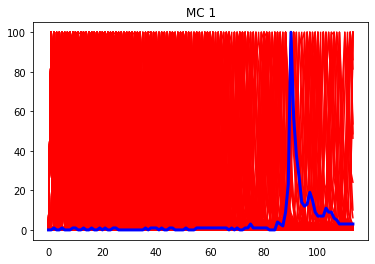

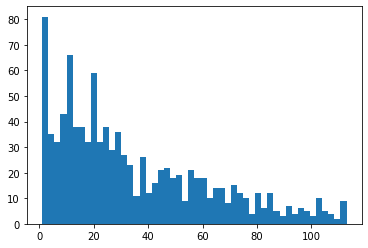

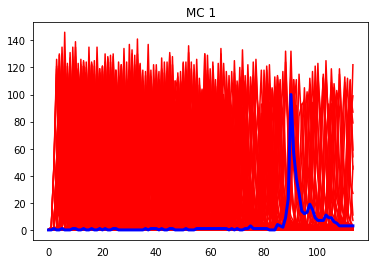

In [11]:
df=pd.read_csv("mc1_no_org_with_metrics.csv")
g_data=pd.read_csv("google-trends.csv")
g_data.columns=['week', 'data']
goog_data= g_data['data'].to_list()

time_list=[]
for i in range(0, 114):
    time_list.append(i)
peak_time_list = []


for i in range(0, len(df)):
    data=df['short list'].iloc[i]
    data_list=data.strip('][').split(', ')
    new_list=[]
    for j in range(0, len(data_list)):
        item=float(data_list[j])
        new_list.append(item)
    val=i
    plt.tick_params(left=True, right=False, labelleft=True, labelbottom=True, bottom=False)
    plt.plot(time_list, new_list, color='red')
    peak = df["peak-time"].iloc[i]
    peak_time_list.append(peak)
plt.plot(time_list, goog_data, color='blue', lw=3, label="google")
plt.title("MC 1")
plt.show()
    #plt.show()
plt.hist(peak_time_list, bins = 50)
plt.show()

for i in range(0, len(df)):
    data=df['unscaled-list'].iloc[i]
    data_list=data.strip('][').split(', ')
    new_list=[]
    for j in range(0, len(data_list)):
        item=float(data_list[j])
        new_list.append(item)
    val=i
    plt.tick_params(left=True, right=False, labelleft=True, labelbottom=True, bottom=False)
    plt.plot(time_list, new_list, color='red')
    peak = df["peak-time"].iloc[i]
    peak_time_list.append(peak)
plt.plot(time_list, goog_data, color='blue', lw=3, label="google")
plt.title("MC 1")
plt.show()
    

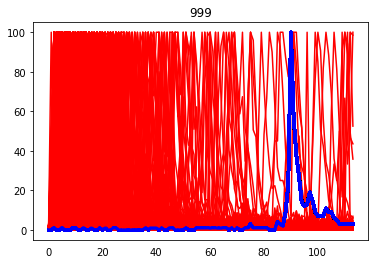

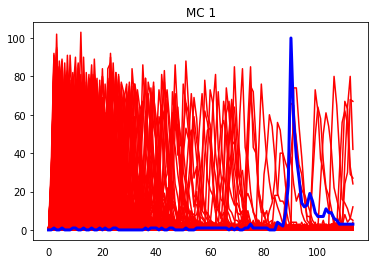

In [12]:
df=pd.read_csv("mc2_no_org_with_metrics.csv")
g_data=pd.read_csv("google-trends.csv")
g_data.columns=['week', 'data']
goog_data= g_data['data'].to_list()

time_list=[]
for i in range(0, 114):
    time_list.append(i)


for i in range(0, len(df)):
    data=df['short list'].iloc[i]
    data_list=data.strip('][').split(', ')
    new_list=[]
    for j in range(0, len(data_list)):
        item=float(data_list[j])
        new_list.append(item)
    val=i
    plt.tick_params(left=True, right=False, labelleft=True, labelbottom=True, bottom=False)
    plt.plot(time_list, new_list, color='red')
    plt.plot(time_list, goog_data, color='blue', lw=3, label="google")
    plt.title(i)
plt.show()
for i in range(0, len(df)):
    data=df['unscaled-list'].iloc[i]
    data_list=data.strip('][').split(', ')
    new_list=[]
    for j in range(0, len(data_list)):
        item=float(data_list[j])
        new_list.append(item)
    val=i
    plt.tick_params(left=True, right=False, labelleft=True, labelbottom=True, bottom=False)
    plt.plot(time_list, new_list, color='red')
    peak = df["peak-time"].iloc[i]
    peak_time_list.append(peak)
plt.plot(time_list, goog_data, color='blue', lw=3, label="google")
plt.title("MC 1")
plt.show()

    

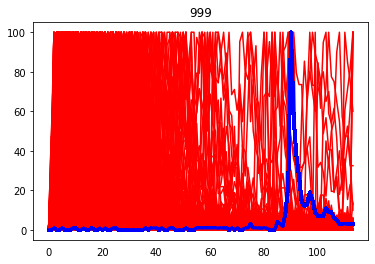

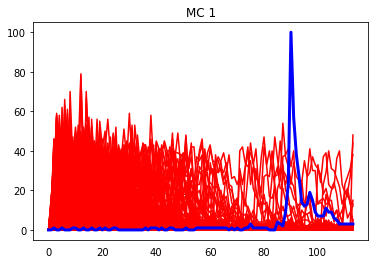

In [15]:
df=pd.read_csv("mc3_no_org_with_metrics.csv")
g_data=pd.read_csv("google-trends.csv")
g_data.columns=['week', 'data']
goog_data= g_data['data'].to_list()

time_list=[]
for i in range(0, 114):
    time_list.append(i)


for i in range(0, len(df)):
    data=df['short list'].iloc[i]
    data_list=data.strip('][').split(', ')
    new_list=[]
    for j in range(0, len(data_list)):
        item=float(data_list[j])
        new_list.append(item)
    val=i
    plt.tick_params(left=True, right=False, labelleft=True, labelbottom=True, bottom=False)
    plt.plot(time_list, new_list, color='red')
    plt.plot(time_list, goog_data, color='blue', lw=3, label="google")
    plt.title(i)
plt.show()

for i in range(0, len(df)):
    data=df['unscaled-list'].iloc[i]
    data_list=data.strip('][').split(', ')
    new_list=[]
    for j in range(0, len(data_list)):
        item=float(data_list[j])
        new_list.append(item)
    val=i
    plt.tick_params(left=True, right=False, labelleft=True, labelbottom=True, bottom=False)
    plt.plot(time_list, new_list, color='red')
    peak = df["peak-time"].iloc[i]
    peak_time_list.append(peak)
plt.plot(time_list, goog_data, color='blue', lw=3, label="google")
plt.title("MC 1")
plt.show()


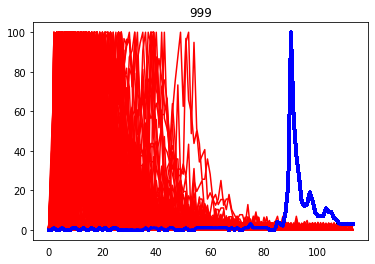

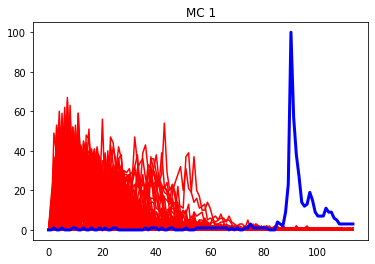

In [18]:
df=pd.read_csv("mc4_no_org_with_metrics.csv")
g_data=pd.read_csv("google-trends.csv")
g_data.columns=['week', 'data']
goog_data= g_data['data'].to_list()

time_list=[]
for i in range(0, 114):
    time_list.append(i)


for i in range(0, len(df)):
    data=df['short list'].iloc[i]
    data_list=data.strip('][').split(', ')
    new_list=[]
    for j in range(0, len(data_list)):
        item=float(data_list[j])
        new_list.append(item)
    val=i
    plt.tick_params(left=True, right=False, labelleft=True, labelbottom=True, bottom=False)
    plt.plot(time_list, new_list, color='red')
    plt.plot(time_list, goog_data, color='blue', lw=3, label="google")
    plt.title(i)
plt.show()

for i in range(0, len(df)):
    data=df['unscaled-list'].iloc[i]
    data_list=data.strip('][').split(', ')
    new_list=[]
    for j in range(0, len(data_list)):
        item=float(data_list[j])
        new_list.append(item)
    val=i
    plt.tick_params(left=True, right=False, labelleft=True, labelbottom=True, bottom=False)
    plt.plot(time_list, new_list, color='red')
    peak = df["peak-time"].iloc[i]
    peak_time_list.append(peak)
plt.plot(time_list, goog_data, color='blue', lw=3, label="google")
plt.title("MC 1")
plt.show()


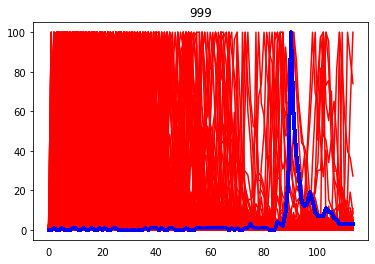

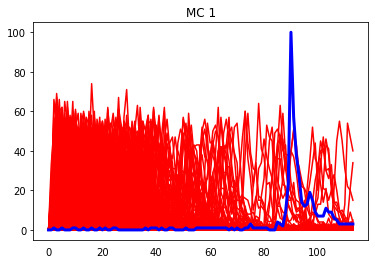

In [17]:
df=pd.read_csv("mc5_no_org_with_metrics.csv")
g_data=pd.read_csv("google-trends.csv")
g_data.columns=['week', 'data']
goog_data= g_data['data'].to_list()

time_list=[]
for i in range(0, 114):
    time_list.append(i)


for i in range(0, len(df)):
    data=df['short list'].iloc[i]
    data_list=data.strip('][').split(', ')
    new_list=[]
    for j in range(0, len(data_list)):
        item=float(data_list[j])
        new_list.append(item)
    val=i
    plt.tick_params(left=True, right=False, labelleft=True, labelbottom=True, bottom=False)
    plt.plot(time_list, new_list, color='red')
    plt.plot(time_list, goog_data, color='blue', lw=3, label="google")
    plt.title(i)
plt.show()

for i in range(0, len(df)):
    data=df['unscaled-list'].iloc[i]
    data_list=data.strip('][').split(', ')
    new_list=[]
    for j in range(0, len(data_list)):
        item=float(data_list[j])
        new_list.append(item)
    val=i
    plt.tick_params(left=True, right=False, labelleft=True, labelbottom=True, bottom=False)
    plt.plot(time_list, new_list, color='red')
    peak = df["peak-time"].iloc[i]
    peak_time_list.append(peak)
plt.plot(time_list, goog_data, color='blue', lw=3, label="google")
plt.title("MC 1")
plt.show()

    

In [42]:
#lets run an experiment with MC 5 on a parallel axis plot
import plotly.express as px
df= pd.read_csv("mc4_org_with_metrics.csv")

#lets set up color by scenario
df["scen"] = None
for i in range(0, len(df)):
    if df["flint-organizing-strategy"].iloc[i] == "neighbors-of-neighbors":
        df["flint-organizing-strategy"].iloc[i] = 1
        if df['organizing-capacity'].iloc[i] == 1:
            df["scen"].iloc[i] = "NoN-1"
            df["scen"].iloc[i] = 1
        if df['organizing-capacity'].iloc[i] == 5:
            df["scen"].iloc[i] = "NoN-5"
            df["scen"].iloc[i] = 2
    if df["flint-organizing-strategy"].iloc[i] == "high-degree-citizens":
        df["flint-organizing-strategy"].iloc[i] = 2
        if df['organizing-capacity'].iloc[i] == 1:
            df["scen"].iloc[i] = "HDC-1"
            df["scen"].iloc[i] = 3
        if df['organizing-capacity'].iloc[i] == 5:
            df["scen"].iloc[i] = "HDC5-1"
            df["scen"].iloc[i] = 4
    if df["flint-organizing-strategy"].iloc[i] == "high-degree-media":
        df["flint-organizing-strategy"].iloc[i] = 3
        if df['organizing-capacity'].iloc[i] == 1:
            df["scen"].iloc[i] = "HDM-1"
            df["scen"].iloc[i] = 5
        if df['organizing-capacity'].iloc[i] == 5:
            df["scen"].iloc[i] = "HDM-1"
            df["scen"].iloc[i] = 6
    if df["flint-organizing-strategy"].iloc[i] == "high-degree-cit-and-media":
        df["flint-organizing-strategy"].iloc[i] = 4
        if df['organizing-capacity'].iloc[i] == 1:
            df["scen"].iloc[i] = "HDCM-1"
            df["scen"].iloc[i] = 7
        if df['organizing-capacity'].iloc[i] == 5:
            df["scen"].iloc[i] = "HDCM-5"
            df["scen"].iloc[i] = 8
            
print(df)
fig = px.parallel_coordinates(df, color="scen",
                              dimensions=['flint-organizing-strategy', 'organizing-capacity','peak-time'])
fig.show()

fig = px.parallel_coordinates(df, color="scen", dimensions = ['flint-organizing-strategy', 'organizing-capacity', 'peak-time'],labels={"flint-organizing-strategy": "Strategy",
                "organizing-capacity": "Capacity", "peak-time": "Time of peak"},
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=4)
fig.show()



C:\Users\cknox02\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



      Unnamed: 0   run    n spread-type  simple-spread-chance  ba-m  \
0              0     0  300      simple                   0.5    10   
1              1     1  300      simple                   0.5    10   
2              2     2  300      simple                   0.5    10   
3              3     3  300      simple                   0.5    10   
4              4     4  300      simple                   0.5    10   
...          ...   ...  ...         ...                   ...   ...   
7995        7995  7995  300      simple                   0.5    10   
7996        7996  7996  300      simple                   0.5    10   
7997        7997  7997  300      simple                   0.5    10   
7998        7998  7998  300      simple                   0.5    10   
7999        7999  7999  300      simple                   0.5    10   

      citizen-media-influence  citizen-citizen-influence  \
0                         0.1                       0.25   
1                         0

In [53]:
df= pd.read_csv("mc4_org_with_metrics.csv")
df["scen"] = None
df['time-bucket']= None
for i in range(0, len(df)):
    if df["flint-organizing-strategy"].iloc[i] == "neighbors-of-neighbors":
        if df['organizing-capacity'].iloc[i] == 1:
            df["scen"].iloc[i] = "NoN-1"
            df["scen"].iloc[i] = 1
        if df['organizing-capacity'].iloc[i] == 5:
            df["scen"].iloc[i] = "NoN-5"
            df["scen"].iloc[i] = 2
    if df["flint-organizing-strategy"].iloc[i] == "high-degree-citizens":
        if df['organizing-capacity'].iloc[i] == 1:
            df["scen"].iloc[i] = "HDC-1"
            df["scen"].iloc[i] = 3
        if df['organizing-capacity'].iloc[i] == 5:
            df["scen"].iloc[i] = "HDC5-1"
            df["scen"].iloc[i] = 4
    if df["flint-organizing-strategy"].iloc[i] == "high-degree-media":
        if df['organizing-capacity'].iloc[i] == 1:
            df["scen"].iloc[i] = "HDM-1"
            df["scen"].iloc[i] = 5
        if df['organizing-capacity'].iloc[i] == 5:
            df["scen"].iloc[i] = "HDM-1"
            df["scen"].iloc[i] = 6
    if df["flint-organizing-strategy"].iloc[i] == "high-degree-cit-and-media":
        if df['organizing-capacity'].iloc[i] == 1:
            df["scen"].iloc[i] = "HDCM-1"
            df["scen"].iloc[i] = 7
        if df['organizing-capacity'].iloc[i] == 5:
            df["scen"].iloc[i] = "HDCM-5"
            df["scen"].iloc[i] = 8
    if df["peak-time"].iloc[i] < 10:
        df["time-bucket"].iloc[i] = 0
    if df["peak-time"].iloc[i] >= 10:
        df["time-bucket"].iloc[i] = 10
    if df["peak-time"].iloc[i] >= 20:
        df["time-bucket"].iloc[i] = 20
    if df["peak-time"].iloc[i] >= 30:
        df["time-bucket"].iloc[i] = 30
    if df["peak-time"].iloc[i] >= 40:
        df["time-bucket"].iloc[i] = 40
    if df["peak-time"].iloc[i] >= 50:
        df["time-bucket"].iloc[i] = 50
    if df["peak-time"].iloc[i] >= 60:
        df["time-bucket"].iloc[i] = 60
    if df["peak-time"].iloc[i] >= 70:
        df["time-bucket"].iloc[i] = 70    
    if df["peak-time"].iloc[i] >= 80:
        df["time-bucket"].iloc[i] = 80
    if df["peak-time"].iloc[i] >= 90:
        df["time-bucket"].iloc[i] = 90
    if df["peak-time"].iloc[i] >= 100:
        df["time-bucket"].iloc[i] = 100
    if df["peak-time"].iloc[i] >= 110:
        df["time-bucket"].iloc[i] = 110
        
        
fig = px.parallel_categories(df, dimensions=['flint-organizing-strategy', 'organizing-capacity', 'time-bucket'],
                color="scen",
                labels={'flint-organizing-strategy':'Strategy', 'organizing-capacity':'Capacity', 'time-bucket':'Time of Peak'})
fig.show()

fig = px.parallel_categories(df, dimensions=['organizing-capacity', 'flint-organizing-strategy', 'time-bucket'],
                color="scen",
                labels={'flint-organizing-strategy':'Strategy', 'organizing-capacity':'Capacity', 'time-bucket':'Time of Peak'})
fig.show()

fig = px.parallel_categories(df, dimensions=['time-bucket', 'flint-organizing-strategy', 'organizing-capacity'],
                color="scen",
                labels={'flint-organizing-strategy':'Strategy', 'organizing-capacity':'Capacity', 'time-bucket':'Time of Peak'})
fig.show()

fig = px.parallel_categories(df, dimensions=['scen', 'time-bucket'],
                color="scen",
                labels={'scen':'Scenario', 'time-bucket':'Time of Peak'})
fig.show()

In [57]:
#lets take round 5- how does organizing change the violin plot

#rn
df= pd.read_csv("mc4_org_with_metrics.csv")
df["scen"] = None
df['time-bucket']= None
for i in range(0, len(df)):
    if df["flint-organizing-strategy"].iloc[i] == "neighbors-of-neighbors":
        if df['organizing-capacity'].iloc[i] == 1:
            df["scen"].iloc[i] = "NoN-1"
            df["scen"].iloc[i] = 1
        if df['organizing-capacity'].iloc[i] == 5:
            df["scen"].iloc[i] = "NoN-5"
            df["scen"].iloc[i] = 2
    if df["flint-organizing-strategy"].iloc[i] == "high-degree-citizens":
        if df['organizing-capacity'].iloc[i] == 1:
            df["scen"].iloc[i] = "HDC-1"
            df["scen"].iloc[i] = 3
        if df['organizing-capacity'].iloc[i] == 5:
            df["scen"].iloc[i] = "HDC5-1"
            df["scen"].iloc[i] = 4
    if df["flint-organizing-strategy"].iloc[i] == "high-degree-media":
        if df['organizing-capacity'].iloc[i] == 1:
            df["scen"].iloc[i] = "HDM-1"
            df["scen"].iloc[i] = 5
        if df['organizing-capacity'].iloc[i] == 5:
            df["scen"].iloc[i] = "HDM-1"
            df["scen"].iloc[i] = 6
    if df["flint-organizing-strategy"].iloc[i] == "high-degree-cit-and-media":
        if df['organizing-capacity'].iloc[i] == 1:
            df["scen"].iloc[i] = "HDCM-1"
            df["scen"].iloc[i] = 7
        if df['organizing-capacity'].iloc[i] == 5:
            df["scen"].iloc[i] = "HDCM-5"
            df["scen"].iloc[i] = 8
            
df_no_org = pd.read_csv("mc1_no_org_with_metrics.csv")
df_no_org["scen"]= 'no org'

df_new = df.append(df_no_org)
print(df)

sns.violinplot(df_new, x="scen", y="peak-time")
plt.show()

C:\Users\cknox02\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



     Unnamed: 0  run    n spread-type  simple-spread-chance  ba-m  \
0             0    0  300      simple                  0.50    10   
1             1    1  300      simple                  0.50    10   
2             2    2  300      simple                  0.50    10   
3             3    3  300      simple                  0.50    10   
4             4    4  300      simple                  0.50    10   
..          ...  ...  ...         ...                   ...   ...   
995         995  995  300      simple                  0.75    10   
996         996  996  300      simple                  0.75    10   
997         997  997  300      simple                  0.75    10   
998         998  998  300      simple                  0.75    10   
999         999  999  300      simple                  0.75    10   

     citizen-media-influence  citizen-citizen-influence  \
0                       0.10                       0.25   
1                       0.10                       0.

C:\Users\cknox02\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



ValueError: Could not interpret input 'peak-time'